This notebook uses the LineDetection class to retrieve the coordinates of streaks in images. The purpose of this notebook is to provide an experimentation space to use that class structure and apply it on various images. 

You must have the line_detection.py file in the same folder as this notebook. Additionally, you should have a "Data" folder containing the images that you want to analyze. So far, this code has been tested on 8 images obtained from the following source:

https://epyc.astro.washington.edu/~dinob/dssg/



In [1]:
#Import the module and other libraries
import line_detection_updated as ld
#import image_rotation
from astropy.io import fits
import astropy.visualization as aviz
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np


from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2



In [2]:
#Set user filepath
'''
Since multiple people are using this file and we may have different filepaths, please set the filepath here. Filepath is basically a string that denotes which folder you want to navigate to. 
So if your datasets are in a folder called Images inside a folder called Home, then you can write current_user_filepath = 'Home/Images'

Please comment out the other users' filepaths, do not delete it. 

For example  --> img1 = fits.open(current_user_filepath + '/calexp-0941420_07.fits', cache = True)

'''
current_user_filepath = '/home/localdir/satmetrics/fitsfiles'





In [3]:
#Import your data
'''
I am pasting 8 images that I worked with to write this code. 
But you can use this format to import any image you want
'''

img1 = fits.open(current_user_filepath + '/calexp-0941420_07.fits', cache = True)
img2 = fits.open(current_user_filepath +'/calexp-0941422_33.fits', cache = True)
img3 = fits.open(current_user_filepath +'/calexp-0941424_34.fits', cache = True)
img4 = fits.open(current_user_filepath +'/calexp-0941426_16.fits', cache = True)
img5 = fits.open(current_user_filepath +'/calexp-0941424_37.fits', cache = True)
# img6 = fits.open(current_user_filepath +'/STARLINK-1892-20220305200929.fits',cache = True)
# img7 = fits.open(current_user_filepath +'/STARLINK-1892-N-20220305200959.fits',cache = True)
# img8 = fits.open(current_user_filepath +'/STARLINK-1905-20220305191929.fits',cache = True)
img_multiple_streaks = fits.open(current_user_filepath + '/bi327715.fits', cache=True )


In [5]:
#Set up your image data
'''
Note:
Please check where the data actually lies in the fits file. You can do that my typing img1.info()
Usually, the image is in the first element i.e. img1[0], but in many cases it can be in the 
2nd element i.e. img1[1]. So before applying the line detection class, make sure your img_data
actually has data

These 2 lines are the code you should change when you want to work with a different image.
'''
#img_data = img2[1].data
img_data = img1[1].data
img_data_copy = img_data.copy()



In [6]:
#Importing the class
detector = ld.LineDetection()




In [7]:
detector.image = img_data_copy
detector.nstd1_cut = 2
detector.nstd2_binary_cut = 0.5
detector.threshold = 0.075
detector.mask = False
'''
OPTIONAL:

detector.mask = True
detector.erode = False
detector.erode_threshold = 5
detector.mask_percent = 0.2
detector.nstd1_cut = 2
detector.nstd2_binary_cut = 0.5
detector.threshold = 0.12

''' 




'\nOPTIONAL:\n\ndetector.mask = True\ndetector.erode = False\ndetector.erode_threshold = 5\ndetector.mask_percent = 0.2\ndetector.nstd1_cut = 2\ndetector.nstd2_binary_cut = 0.5\ndetector.threshold = 0.12\n\n'

Found 2 lines.


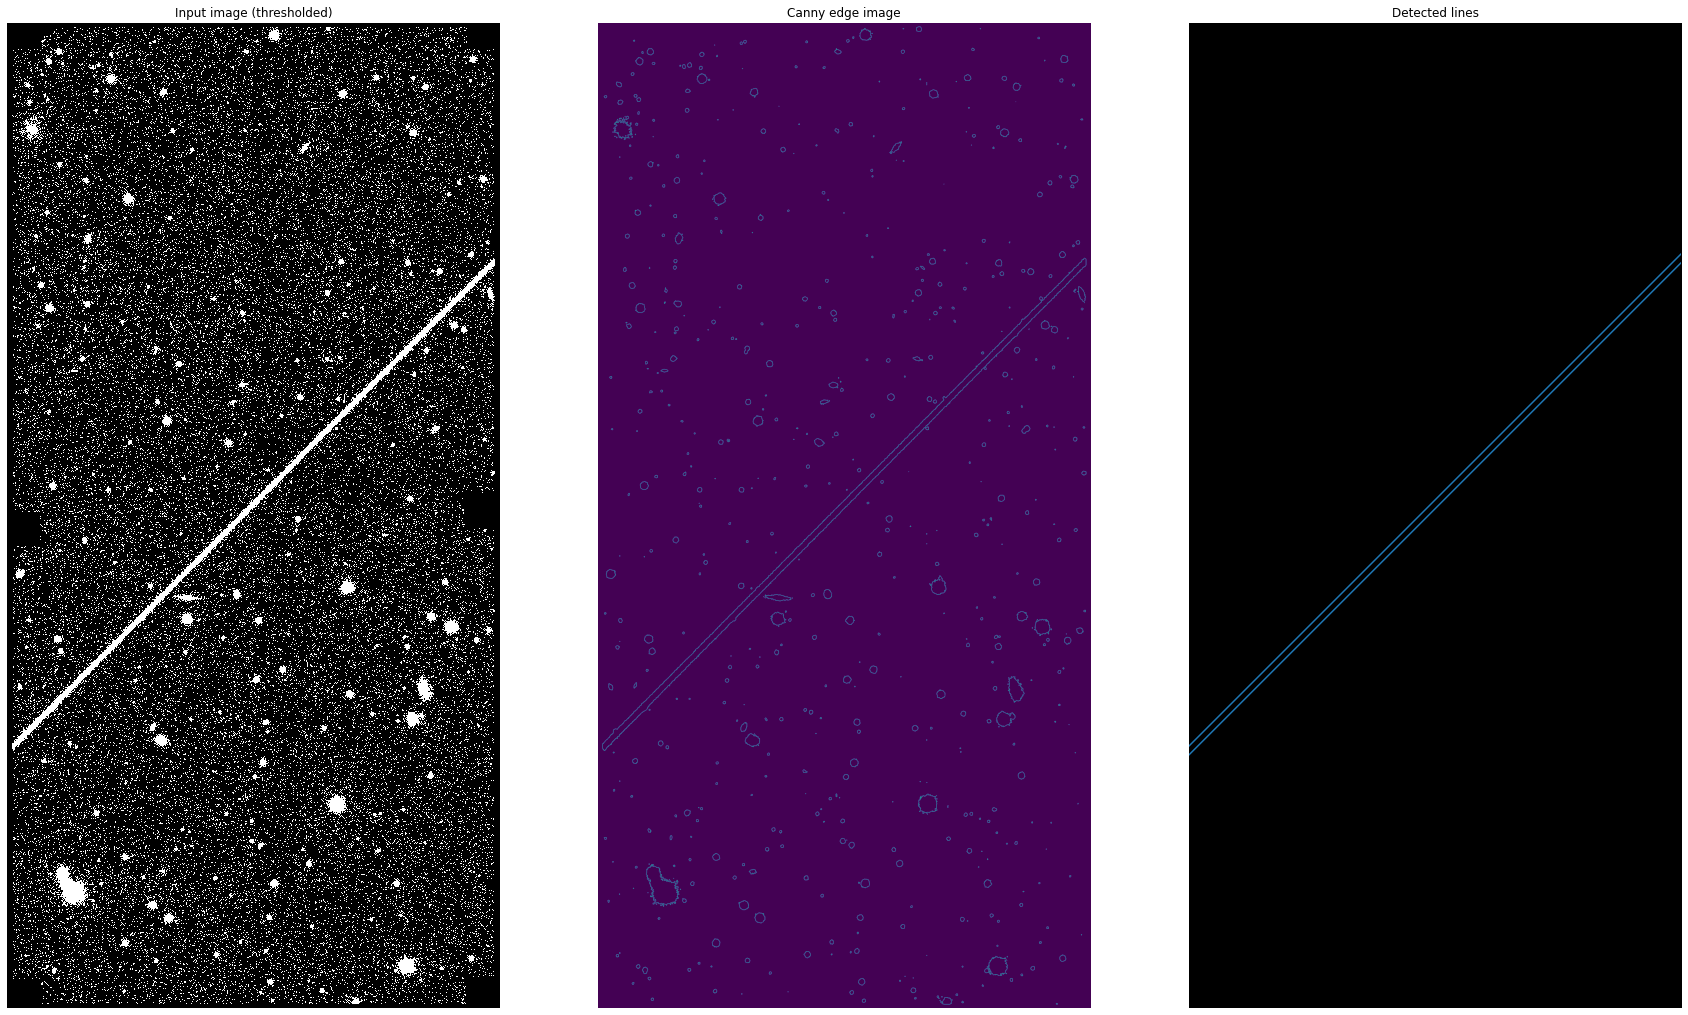

In [8]:
#Conduct the line detection
lines, angles, cart_coords, thresholded_image, blurred_image, edges, contours_img = detector.hough_transformation()

#Visualize input image and detected lines
fig, axes = plt.subplots(1, 3, figsize=(30, 30))
ax = axes.ravel()

ld.show(thresholded_image, cmap="gray", ax=ax[0], interpolation="none")
ax[0].set_title('Input image (thresholded)')
ax[0].set_axis_off()

ld.show(edges, ax=ax[1])
ax[1].set_title('Canny edge image')
ax[1].set_axis_off()

#Detected lines
blank_image = np.zeros(detector.image.shape)

ld.show(blank_image, cmap="gray", ax=ax[2])

ax[2].set_axis_off()
ax[2].set_title('Detected lines')

for i in range(len(cart_coords)):
    ax[2].axline(cart_coords[i], slope=np.tan(angles[i] + np.pi/2))


In [9]:
lines

array([[2.12600000e+03, 7.85398163e-01],
       [2.15200000e+03, 7.85398163e-01]])

In [10]:
angles = np.array(angles)
angles

array([0.78539816, 0.78539816])

In [11]:
cart_coords = np.array(cart_coords)
cart_coords

array([[1503.3090168 , 1503.3090168 ],
       [1521.69379311, 1521.69379311]])

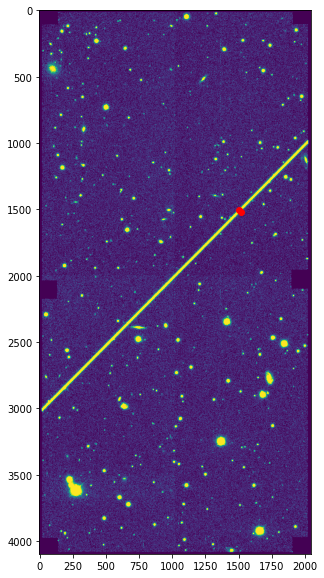

In [12]:
plt.imshow(thresholded_image)
plt.scatter(cart_coords[:,0], cart_coords[:,1], color = 'red')

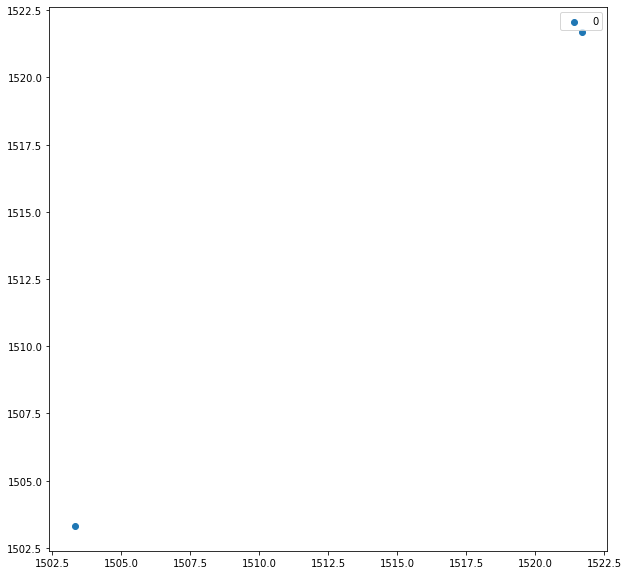

In [13]:
#Clustering the detected lines
clustered_lines = ld.cluster(cart_coords, lines)

In [14]:
clustered_lines = np.array(clustered_lines)


In [15]:
def rotate_image(image, angle, coordinates):

    #finding midpoint of line to find point of rotation
    #because pixels have to be integers, this midpoint will be an estimate      

    #rotating original image without crop

    rotation_x = (coordinates[1][0] + coordinates[0][0]) // 2
    rotation_y = (coordinates[1][1] + coordinates[0][1]) // 2

    matrix = cv2.getRotationMatrix2D((rotation_x, rotation_y), angle, 1.0)
    rotated_image = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))

    #cropping image
    # rotated_image = rotated_image[int(rotation_y - 50): int(rotation_y + 50)]

    return rotated_image

In [16]:
thresholded_image.shape

(4096, 2048)

In [17]:
    def get_coord(rho, theta, image):
        '''Finds Cartesian Coordinates of a line at the edge of image given the radius and angle
        in Polar Coordinates
        
        Parameters
        __________
        rho : 'float'
        Radius of detected line in Polar Coordinates
        
        theta : 'float'
        Angle of detected line in Polar Coordinates
        '''

        x_size = image.shape[1]
        y_size = image.shape[0]

        #first guess coordinates if they are within the boundaries of the image
        one = [0, rho / np.sin(theta)]
        two = [rho / np.cos(theta), 0]
        three = [x_size, -1 * (np.cos(theta) / np.sin(theta) * x_size) + (rho / np.sin(theta))]
        four = [(-1 * (np.sin(theta) / np.cos(theta)) * y_size) + (rho / np.cos(theta)), y_size]

        validate = [one, two, three, four]
        validate = np.array(validate)
        val_x = validate[:,0]
        val_y = validate[:,1]

        bool_x = [0 <= val_x[i] <= x_size for i in range(4)]
        bool_y = [0 <= val_y[i] <= x_size for i in range(4)]
        true_bool = [bool_x[i] & bool_y[i] for i in range(4)]
        
        final_coord = validate[true_bool]
        return final_coord

In [31]:
def coord_all_lines(polar_coor, image):
    #takes list of (rho, theta) coordinates and returns a list of converted cartesian coordinates
    coordinates = [get_coord(line[0],line[1], image) for line in polar_coor]
    print(coordinates)
    return coordinates

In [26]:
def summarized_coordinates(coordinates):
    '''Finds mean edge cartesian coordinates of all Hough Transform lines
    
    Parameters
    __________
    coordinates : 'list'
    List of two pair of cartesian coordinates for each line, where one pair is where
    the streak enters the image and the other is where the streak exits the image 
    '''
    #creates a single list with clusters of x1, y1, x2, y2 values
    points_sep = [points[i][j] for i in range(2) for j in range(2) for points in coordinates]
    #determining the number of elements in each cluster of subcoordinates (e.g. the number of total x1s)
    mod = int(len(points_sep)/4)

    #finding finding mean or median of each subcoordinate to generate entrance and exit coordinates
    summ_coor = [np.mean(points_sep[i * mod : ((i + 1) * mod)]) for i in range(4)]
    self.mean = ([summ_coor[0], summ_coor[1]], [summ_coor[2], summ_coor[3]])

    return [summ_coor[0], summ_coor[1]], [summ_coor[2], summ_coor[3]]

In [32]:
rot_images = []

ncluster = int(max(clustered_lines[:,2])) + 1

for i in range(ncluster):
    cur_cluster = clustered_lines[clustered_lines[:,2] == i][:,0:2] #row such that the cluster equals the i value: clustered_lines

    if len(cur_cluster) == 1:
        cur_angle = angles[clustered_lines[:,2] == i]
        cur_angle = (cur_angle * 180 / np.pi) - 90
        cur_angle = cur_angle[0]

        coord = get_coord(rho = cur_cluster[0][0], theta = cur_cluster[0][1], image = thresholded_image)
        rotated_image = rotate_image(image = thresholded_image, angle  = cur_angle, coordinates = coord)
        rot_images.append(rotated_image)

    else:
        list_coord = coord_all_lines(cur_cluster, thresholded_image)
        coord = summarized_coordinates(coord)



        # cur_angle = angles[clustered_lines[:,2] == i]
        # cur_angle = [((ang * 180 / np.pi) - 90) for ang in cur_angle]
        # print(cur_angle)

            


[[2048.          958.61803361]]
[[2048.          995.38758623]]
[array([[2048.        ,  958.61803361]]), array([[2048.        ,  995.38758623]])]


In [21]:
fig, axes = plt.subplots(1, len(rot_images), figsize=(30, 30))
ax = axes.ravel()

for i in range(len(rot_images)):
    ld.show(rot_images[i], ax=ax[i], interpolation="none")

ValueError: Number of columns must be a positive integer, not 0

<Figure size 2160x2160 with 0 Axes>

In [ ]:
print(clustered_lines[:,2] == 1)

[False False False False False False False False  True  True False False]
